In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '23'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20240413SATFB4505', '2024-Apr-13', '00:00:00', 'Finnish Division 1 [FVL]', 'VPS Vaasa', 'SJK Seinajoki', 'true', '9.5', '1.81', '1.89', 'false', '10.5', '2.29', '1.55', 'false', '12.5', '3.65', '1.23']
['20240413SATFB4493', '2024-Apr-13', '00:30:00', 'German Division 2 [GD2]', 'Hertha Berlin', 'Rostock', 'true', '10.5', '1.74', '1.97', 'false', '11.5', '2.15', '1.62', 'false', '14.5', '4.30', '1.16']
['20240413SATFB4494', '2024-Apr-13', '00:30:00', 'German Division 2 [GD2]', 'Greuther Furth', 'Kaiserslautern', 'true', '10.5', '2.00', '1.72', 'false', '11.5', '2.55', '1.45', 'false', '13.5', '4.15', '1.17']
['20240413SATFB4504', '2024-Apr-13', '01:00:00', 'Finnish Division 1 [FVL]', 'Inter Turku', 'AC Oulu', 'true', '9.5', '1.83', '1.87', 'false', '10.5', '2.30', '1.54', 'false', '13.5', '4.75', '1.13']
['20240413SATFB4491', '2024-Apr-13', '02:00:00', 'Dutch Division 1 [DFL]', 'Excelsior', 'Volendam', 'true', '11.5', '2.17', '1.61', 'false', '12.5', '2.70', '1.39', 'false', '14.5', '4

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = [o for o in odds if len(o) == 18]

In [13]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [14]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [15]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20240413SATFB4505,2024-Apr-13,00:00:00,Finnish Division 1 [FVL],VPS Vaasa,SJK Seinajoki,true,9.5,1.81,1.89,false,10.5,2.29,1.55,false,12.5,3.65,1.23
1,20240413SATFB4493,2024-Apr-13,00:30:00,German Division 2 [GD2],Hertha Berlin,Rostock,true,10.5,1.74,1.97,false,11.5,2.15,1.62,false,14.5,4.30,1.16
2,20240413SATFB4494,2024-Apr-13,00:30:00,German Division 2 [GD2],Greuther Furth,Kaiserslautern,true,10.5,2.00,1.72,false,11.5,2.55,1.45,false,13.5,4.15,1.17
3,20240413SATFB4504,2024-Apr-13,01:00:00,Finnish Division 1 [FVL],Inter Turku,AC Oulu,true,9.5,1.83,1.87,false,10.5,2.30,1.54,false,13.5,4.75,1.13
4,20240413SATFB4491,2024-Apr-13,02:00:00,Dutch Division 1 [DFL],Excelsior,Volendam,true,11.5,2.17,1.61,false,12.5,2.70,1.39,false,14.5,4.30,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,20240416TUEFB4661,2024-Apr-16,02:30:00,Spanish Division 2 [SF2],Alcorcon,Villarreal B,true,8.5,1.80,1.90,false,12.5,5.15,1.11,false,9.5,2.25,1.57
115,20240416TUEFB4600,2024-Apr-16,03:00:00,Eng Premier [EPL],Chelsea,Everton,true,11.5,2.07,1.67,false,12.5,2.60,1.43,false,14.5,4.30,1.16
116,20240416TUEFB4554,2024-Apr-16,03:00:00,Spanish Division 1 [SFL],Osasuna,Valencia,true,8.5,1.88,1.82,false,11.5,4.15,1.17,false,9.5,2.40,1.50
117,20240416TUEFB4734,2024-Apr-16,07:00:00,Argentine Division 1 [APL],Argentinos Juniors,Barracas Central,true,9.5,1.95,1.75,false,10.5,2.55,1.45,false,12.5,4.30,1.16


In [16]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [17]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [18]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [19]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF', 'EFA', 'SFC']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [20]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [21]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [22]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [23]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [24]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [25]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [26]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [27]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [28]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [29]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [30]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [31]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [32]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [33]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [34]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SATFB4493,SATFB4494,SATFB4541,SATFB4543,SATFB4542
Date,2024-04-13 00:00:00,2024-04-13 00:00:00,2024-04-13 00:00:00,2024-04-13 00:00:00,2024-04-13 00:00:00
Time,00:30:00,00:30:00,19:00:00,19:00:00,19:00:00
LeagueJC,German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2]
HomeTeamJC,Hertha Berlin,Greuther Furth,Paderborn,Holstein Kiel,Wehen
AwayTeamJC,Rostock,Kaiserslautern,Karlsruher,Osnabruck,Dusseldorf
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,10.5,10.5,11.5,11.5,10.5
CHL_H_0,1.74,2.0,2.05,2.0,2.15
CHL_L_0,1.97,1.72,1.68,1.72,1.62


## Load model

In [35]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [36]:
to = load_pandas('models/to.pkl')

In [37]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [38]:
odds = odds.dropna(how='any')

In [39]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [40]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,D2,Hertha,Hansa Rostock,13.4,5.4,11.2,4.8,12.4,12.4,13.6,15.2
1,D2,Greuther Furth,Kaiserslautern,15.8,6.8,14.6,5.4,11.2,12.2,14.0,8.4
2,D2,Paderborn,Karlsruhe,15.0,8.0,13.0,5.8,15.6,15.2,9.8,11.8
3,D2,Holstein Kiel,Osnabruck,17.0,5.8,10.8,4.8,14.0,6.6,12.0,17.2
4,D2,Wehen,Fortuna Dusseldorf,10.0,2.6,10.8,4.4,13.4,12.0,12.2,14.0
5,D2,Schalke 04,Nurnberg,17.2,7.0,9.4,4.4,14.4,8.6,13.4,15.0
6,D2,Braunschweig,Hannover,13.0,4.2,12.6,5.2,12.6,16.2,15.4,9.4
7,D2,Magdeburg,Hamburg,14.4,7.0,12.4,3.8,11.2,14.6,16.4,7.4
8,D2,St Pauli,Elversberg,18.4,7.0,14.4,4.2,12.2,13.2,8.4,14.4
9,D1,Augsburg,Union Berlin,11.2,4.0,9.8,2.6,17.6,11.2,9.6,12.6


In [41]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [42]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [43]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [44]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [45]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [46]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [47]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [48]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SATFB4493,2024-04-13,00:30:00,German Division 2 [GD2],Hertha Berlin,Rostock,True,10.5,1.74,1.97,0.056881,0.104447,5.964690,3.702497,-48.052788,-0.123183
1,SATFB4494,2024-04-13,00:30:00,German Division 2 [GD2],Greuther Furth,Kaiserslautern,True,10.5,2.00,1.72,0.093461,0.098186,4.819311,4.855031,-48.053635,-0.179750
2,SATFB4541,2024-04-13,19:00:00,German Division 2 [GD2],Paderborn,Karlsruher,True,11.5,2.05,1.68,0.069524,0.080168,5.048598,5.034387,-50.973534,-0.130853
3,SATFB4543,2024-04-13,19:00:00,German Division 2 [GD2],Holstein Kiel,Osnabruck,True,11.5,2.00,1.72,0.052035,0.100649,6.389311,4.093875,-51.845036,-0.127204
4,SATFB4542,2024-04-13,19:00:00,German Division 2 [GD2],Wehen,Dusseldorf,True,10.5,2.15,1.62,0.054737,0.083169,6.077805,4.749570,-53.720886,-0.121924


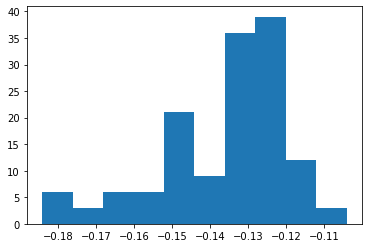

In [49]:
odds['corr'].hist(grid=False);

In [50]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [51]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [52]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [53]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [54]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [55]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [56]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.35, '$$$', np.where(
            odds['kelly']>0.25, '$$', np.where(
                odds['kelly']>0.15, '$', None))), 
    None
)

In [57]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [58]:
odds[odds.bet.notna() & odds.selected.notna()].reset_index(drop=True)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SATFB4492,2024-04-13,02:30:00,German Division 1 [GSL],Augsburg,Union Berlin,True,10.5,2.20,1.59,0.253503,0.746497,0.316830,Low,$$
1,SUNFB4531,2024-04-14,19:30:00,German Division 2 [GD2],Magdeburg,Hamburg,True,10.5,1.85,1.85,0.346533,0.653467,0.245780,Low,$
2,SUNFB4512,2024-04-14,00:30:00,Eng Premier [EPL],Bournemouth,Manchester Utd,True,12.5,1.94,1.76,0.330242,0.669758,0.235228,Low,$
3,SATFB4493,2024-04-13,00:30:00,German Division 2 [GD2],Hertha Berlin,Rostock,True,10.5,1.74,1.97,0.378199,0.621801,0.231905,Low,$
4,SUNFB4566,2024-04-14,03:00:00,French Division 1 [FFL],Rennes,Toulouse,True,9.5,1.90,1.80,0.342439,0.657561,0.229512,Low,$
5,SATFB4508,2024-04-13,22:00:00,Eng Premier [EPL],Nottingham Forest,Wolves,True,10.5,1.93,1.77,0.336176,0.663824,0.227232,Low,$
6,SATFB4514,2024-04-13,22:00:00,Eng Premier [EPL],Manchester City,Luton,True,12.5,2.08,1.66,0.309424,0.690576,0.221752,Low,$
7,SATFB4541,2024-04-13,19:00:00,German Division 2 [GD2],Paderborn,Karlsruher,True,11.5,2.05,1.68,0.321371,0.678629,0.206025,Low,$
8,TUEFB4600,2024-04-16,03:00:00,Eng Premier [EPL],Chelsea,Everton,True,11.5,2.07,1.67,0.326354,0.673646,0.186550,Low,$
9,SUNFB4507,2024-04-14,21:00:00,Eng Premier [EPL],West Ham,Fulham,True,11.5,2.25,1.57,0.296200,0.703800,0.184152,Low,$


In [59]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SATFB4492,2024-04-13,02:30:00,German Division 1 [GSL],Augsburg,Union Berlin,False,13.5,4.40,1.15,0.069712,0.930288,0.465539,Low,None
1,SATFB4493,2024-04-13,00:30:00,German Division 2 [GD2],Hertha Berlin,Rostock,False,14.5,4.30,1.16,0.085694,0.914306,0.378718,Low,None
2,SATFB4492,2024-04-13,02:30:00,German Division 1 [GSL],Augsburg,Union Berlin,False,11.5,2.75,1.38,0.172556,0.827444,0.373348,Low,None
3,SUNFB4531,2024-04-14,19:30:00,German Division 2 [GD2],Magdeburg,Hamburg,False,14.5,4.75,1.13,0.073222,0.926778,0.363529,Low,None
4,SUNFB4566,2024-04-14,03:00:00,French Division 1 [FFL],Rennes,Toulouse,False,13.5,5.15,1.11,0.064868,0.935132,0.345423,Low,None
5,SUNFB4512,2024-04-14,00:30:00,Eng Premier [EPL],Bournemouth,Manchester Utd,False,16.5,4.75,1.13,0.078536,0.921464,0.317337,Low,None
6,SATFB4492,2024-04-13,02:30:00,German Division 1 [GSL],Augsburg,Union Berlin,True,10.5,2.20,1.59,0.253503,0.746497,0.316830,Low,$$
7,SATFB4534,2024-04-13,21:30:00,German Division 1 [GSL],Monchengladbach,Dortmund,False,14.5,4.05,1.18,0.104806,0.895194,0.312939,Low,None
8,SUNFB4512,2024-04-14,00:30:00,Eng Premier [EPL],Bournemouth,Manchester Utd,False,13.5,2.35,1.52,0.243646,0.756354,0.287804,Low,None
9,SUNFB4531,2024-04-14,19:30:00,German Division 2 [GD2],Magdeburg,Hamburg,False,11.5,2.33,1.53,0.250742,0.749258,0.276161,Low,None


In [60]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)